In [1]:
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
from libmtf import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

In [2]:
def plot_images(image_left, image_right):
    plt.subplot(1, 2, 1)
    plt.title("image left")
    plt.imshow(image_left, "gray")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title("image right")
    plt.imshow(image_right, cmap="hot")
    plt.colorbar()

def load_image(filename):
    image = read_image(filename)
    return image

def get_roimage(image, topleft, bottomright, rotation):
    roi_image, roi = get_roi(image, topleft, bottomright)
    roi_image = rotate(roi_image, rotation)
    return roi_image, roi

def get_derivative(roi_image):
    deriv = roi_image
    return roi_image

def plot_derivatives(deriv):
    plt.subplot(1, 2, 1)
    plt.title("LSF for all rows")
    for i in range(deriv.shape[0]):
        plt.plot(deriv[i, :])
    
    plt.subplot(1, 2, 2)
    plt.title("LSF for first row")
    plt.plot(deriv[0,:])      

def get_fit(curve):
    x = np.arange(len(curve))
    y = curve
    fit = get_polyfit(x, y, 1)
    return fit
    
def get_centroid_and_fit(deriv, hamming_win):
    centroid = get_centroid(deriv * hamming_win) - 0.5
    fit = get_fit(centroid)
    return centroid, fit

def plot_centroid(image, centroid, fit):
    plt.title("LSF and fittings")
    plt.imshow(image)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid

    plt.plot(np.polyval(fit, x), x, "y")

def plot_lsf(lsf_curve, centroid, fit, roi_image_limited):
    plt.subplot(1, 2, 1)
    plt.title("LSF after Hamming window")
    plt.imshow(lsf_curve)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid
    plt.plot(np.polyval(fit, x), x, "y")

    plt.subplot(1, 2, 2)
    plt.title("LSF limted")
    plt.imshow(roi_image_limited)

def fit_central(fit, centroid, deriv_v, win1_v):
    centroid_place = np.polyval(fit, np.arange(len(centroid)))
    hamming_width = deriv_v.shape[1]

    win2 = [get_hamming(hamming_width, centroid_place[i]) for i in range(len(centroid_place))]
    win2 = np.array(win2)
    deriv_hamming_windowed = deriv_v*win2

    centroid, fit = get_centroid_and_fit(deriv_hamming_windowed, win1_v)

    slout_ = -fit[0]
    slout = 180*math.atan(slout_)/math.pi

    # Evaluate equation at the middle line as edge location
    midloc = np.polyval(fit, deriv_v.shape[0]/2)

    # Limit number of lines to integer (npix*line slope as per ISO 12233
    nlin = deriv_v.shape[0]
    a = math.floor(nlin*abs(slout))
    b = abs(slout)
    nlin1 = round(a/b)

    roi_image_limited = deriv_hamming_windowed[:nlin1, :]

    plot_lsf(deriv_hamming_windowed, centroid, fit, roi_image_limited)

    vslope = -fit[0]
    slope_deg = slout
    delimage = 1

    # correct sampling interval for sampling normal to edge
    delfac = math.cos(math.atan(vslope))

    # input pixel sampling normal to edge
    del1n = delfac
    nbin = 4
    # super-sampling interval normal to edge
    del2 = del1n/nbin

    nn = math.ceil(deriv_hamming_windowed.shape[1]*nbin)
    nn2 = math.floor(nn/2) + 1

    # dcorr corrects SFR for response of FIR filter
    dcorr = get_fir2fix(nn2, 3)

    freqlim = 1
    if nbin == 1:
        freqlim = 2
        
    nn2out = round(nn2*freqlim/2)

    # half-sampling frequency
    nfreq = nn/(2*delimage*nn)    

    return roi_image_limited, nbin, nn2, del2

def get_mtf(lsf, nn2, del2):
    temp = abs(fft(lsf))
    mtf = temp[0:nn2] / temp[0]
    # Compute frequency values
    # print("del2", del2, "nn", nn)
    freq = [i / (del2*nn) for i in range(nn)]
    freq = np.array(freq)
    mtf = np.array(mtf)

    nn_2_out = 30
    nn2out=nn_2_out # for smartmtf
    efl = 60
    px = 3.45

    lppd = px/efl/1000 * 180/3.14159

    freq_data = freq[0:nn2out]/lppd
    mtf_data = mtf[0:nn2out]

    return freq_data, mtf_data

def plot_mtf(freq_data, mtf_data):
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.plot(freq_data, mtf_data, label='vline_red_horizontal+22deg')
    plt.legend()

In [3]:
filename = "red_hori_+22deg_2222_rot.png"

# step 0: load image
image = load_image(filename)

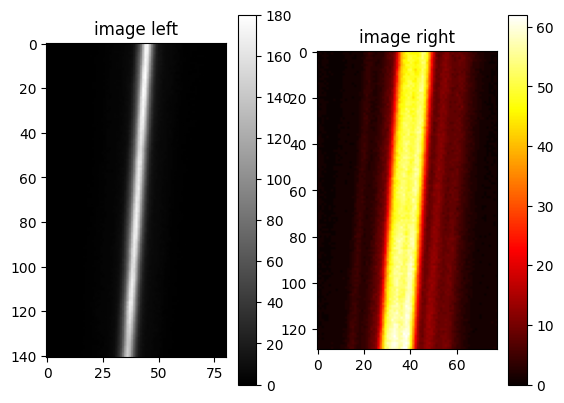

In [4]:
# step 1: get ROI
roi_image_h, roi = get_roimage(image, (1068, 1281), (1209, 1362), 90)
roi_image_v, roi = get_roimage(image, (1248, 1155), (1326, 1284), 0)
plot_images(roi_image_h, roi_image_v)

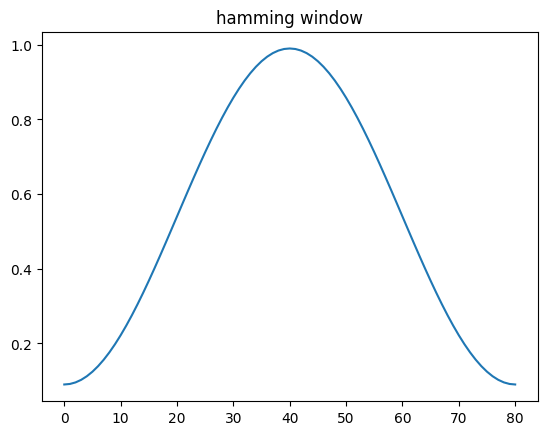

In [5]:
# step 2: hamming window
win1_h = get_hamming(roi_image_h.shape[1])
win1_v = get_hamming(roi_image_v.shape[1])
plt.title("hamming window")
plt.plot(win1_h)

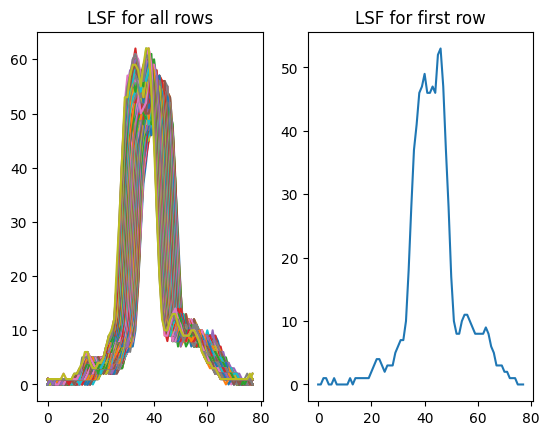

In [6]:
# step 3: get derivative
deriv_h = get_derivative(roi_image_h)
deriv_v = get_derivative(roi_image_v)
plot_derivatives(deriv_v)

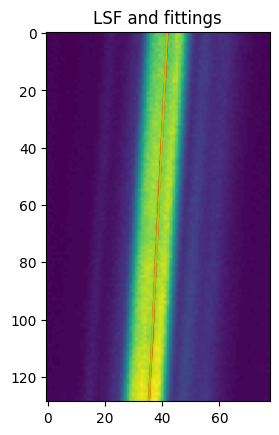

In [7]:
# step 4: apply window and compute centroid
centroid, fit = get_centroid_and_fit(deriv_v, win1_v)
plot_centroid(deriv_v, centroid, fit)

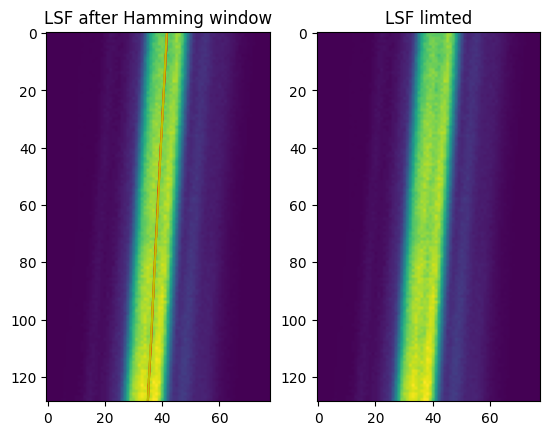

In [8]:
# step 5: compute polynomial fit to central locations


roi_image_limited, nbin, nn2, del2 = fit_central(fit, centroid, deriv_v, win1_v)

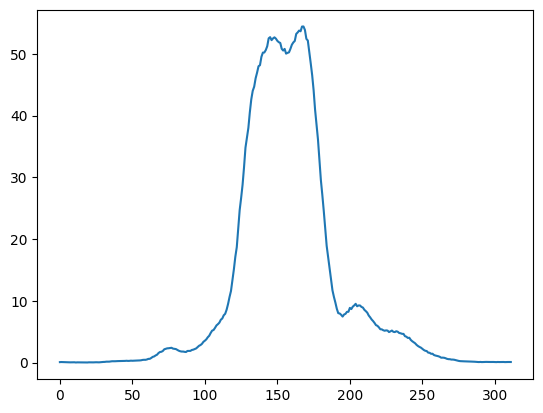

In [9]:
# step 6: super-sample
esf = project2(roi_image_limited, fit, nbin)
l = len(esf)
esf[l-1] = esf[l-2]
plt.plot(esf)    


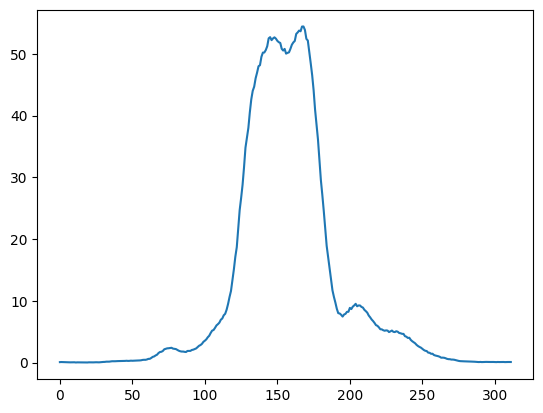

In [10]:
 # step 7: compute 1D derivative (LSF)
lsf1 = esf

plt.plot(lsf1)

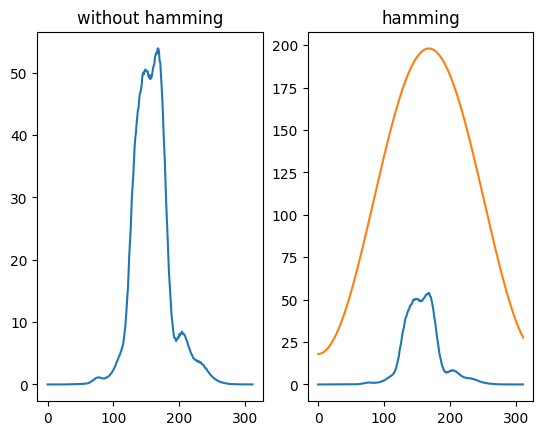

In [11]:
# step 8: apply window to LSF
nn = len(lsf1)
mm = np.argmax(lsf1)

win3 = get_hamming(nn, mm)
win3 = np.array(win3)
lsf1 = np.array(lsf1)
lsf = lsf1 * win3

plt.subplot(1, 2, 1)
plt.title("without hamming")
plt.plot(lsf)

plt.subplot(1, 2, 2)
plt.title("hamming")
plt.plot(lsf1 * win3)
plt.plot(win3*200)    

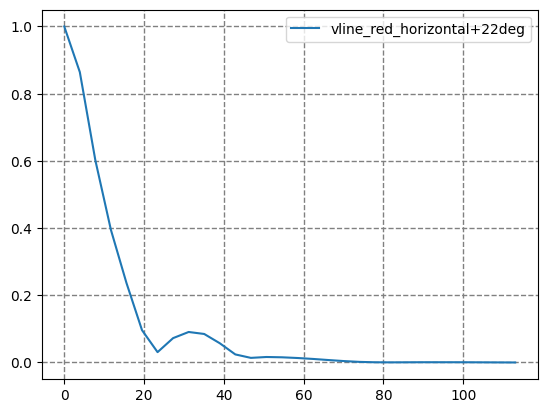

In [12]:
# step 9: MTF
freq_data, mtf_data = get_mtf(lsf, nn2, del2)
plot_mtf(freq_data, mtf_data)
